In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121
from colorama import Fore, Style, init
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Initialize colorama for colored terminal output
init(autoreset=True)

# Function to load data
def load_data(directory, label):
    filepaths = []
    labels = []
    for file in os.listdir(directory):
        filepaths.append(os.path.join(directory, file))  # Get full file path
        labels.append(label)  # Assign label to each file
    return filepaths, labels

# Specify directories containing "black bear" and "newfoundland" images
black_bear_dir = "data/black bear"
newfoundland_dir = "data/newfoundland"

# Load data from directories
black_bear_files, black_bear_labels = load_data(black_bear_dir, 'black bear')
newfoundland_files, newfoundland_labels = load_data(newfoundland_dir, 'newfoundland')

# Combine data into a single DataFrame
filepaths = black_bear_files + newfoundland_files
labels = black_bear_labels + newfoundland_labels
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)


In [3]:
# Function to create data generators
def create_generators(train_df, val_df, test_df, img_size=(224, 224), batch_size=32):
    # ImageDataGenerator for training with rescaling
    train_datagen = ImageDataGenerator(rescale=1./255)
    # ImageDataGenerator for validation and testing with rescaling
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Training data generator
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filepath',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Validation data generator
    val_generator = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='filepath',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Test data generator
    test_generator = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col='filepath',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

# Create data generators
train_generator, val_generator, test_generator = create_generators(train_df, val_df, test_df)

Found 374 validated image filenames belonging to 2 classes.
Found 94 validated image filenames belonging to 2 classes.
Found 118 validated image filenames belonging to 2 classes.


In [4]:
# Function to build the model
def build_model(base_model, num_classes, dropout_rate=0.25):
    model = Sequential([
        base_model,  # Base model (DenseNet121)
        BatchNormalization(),  # Add batch normalization layer
        Dropout(dropout_rate),  # Add dropout layer
        Flatten(),  # Flatten the output
        Dense(128, activation='relu'),  # Fully connected layer with 128 units
        Dropout(dropout_rate),  # Add dropout layer
        Dense(num_classes, activation='softmax')  # Output layer with softmax activation
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load the base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers
num_classes = len(train_generator.class_indices)  # Number of classes
model = build_model(base_model, num_classes)  # Build the model

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1024)       4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [5]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Early stopping callback

# Fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping]
)

Epoch 1/15
12/12 [==============================] - 77s 5s/step - loss: 0.4199 - accuracy: 0.9171 - val_loss: 0.5813 - val_accuracy: 0.9574
Epoch 2/15
12/12 [==============================] - 57s 5s/step - loss: 0.0025 - accuracy: 0.9973 - val_loss: 0.1359 - val_accuracy: 0.9894
Epoch 3/15
12/12 [==============================] - 57s 5s/step - loss: 0.0338 - accuracy: 0.9947 - val_loss: 1.9655e-04 - val_accuracy: 1.0000
Epoch 4/15
12/12 [==============================] - 57s 5s/step - loss: 0.0048 - accuracy: 0.9973 - val_loss: 2.4709e-05 - val_accuracy: 1.0000
Epoch 5/15
12/12 [==============================] - 58s 5s/step - loss: 2.6410e-04 - accuracy: 1.0000 - val_loss: 2.1426e-05 - val_accuracy: 1.0000
Epoch 6/15
12/12 [==============================] - 54s 4s/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 1.0780e-07 - val_accuracy: 1.0000
Epoch 7/15
12/12 [==============================] - 58s 5s/step - loss: 0.0267 - accuracy: 0.9947 - val_loss: 4.7175e-07 - val_accuracy: 1.0

In [6]:
# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(val_generator)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Save the model
model.save('model/my_model.h5')
print("Model saved to 'model/my_model.h5'")

3/3 [==============================] - 12s 4s/step - loss: 1.4824e-06 - accuracy: 1.0000
Validation Loss: 1.482404059061082e-06
Validation Accuracy: 1.0
Model saved to 'model/my_model.h5'


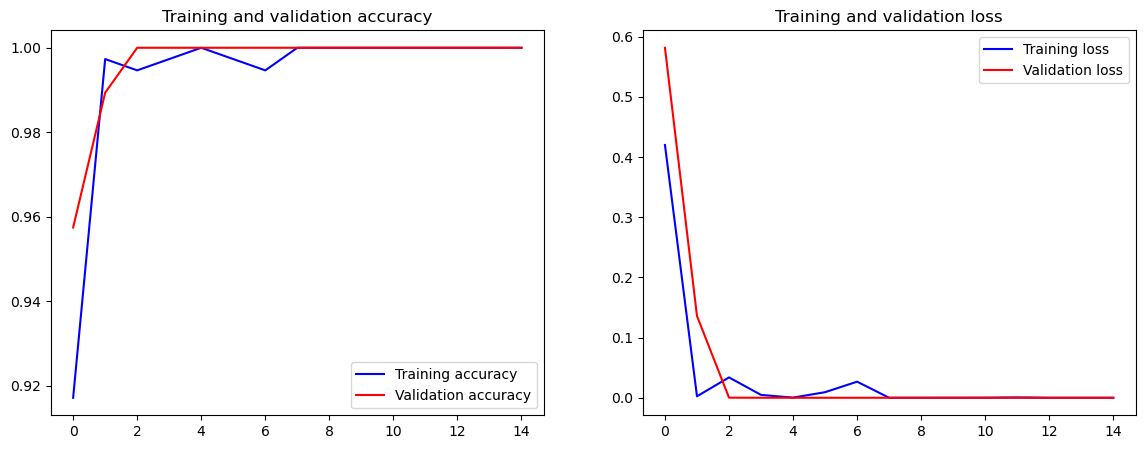

In [7]:
# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']  # Training accuracy
    val_acc = history.history['val_accuracy']  # Validation accuracy
    loss = history.history['loss']  # Training loss
    val_loss = history.history['val_loss']  # Validation loss
    epochs = range(len(acc))  # Number of epochs

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.savefig('training_history.png')  # Save as image
    plt.show()

# Plot training history
plot_training_history(history)

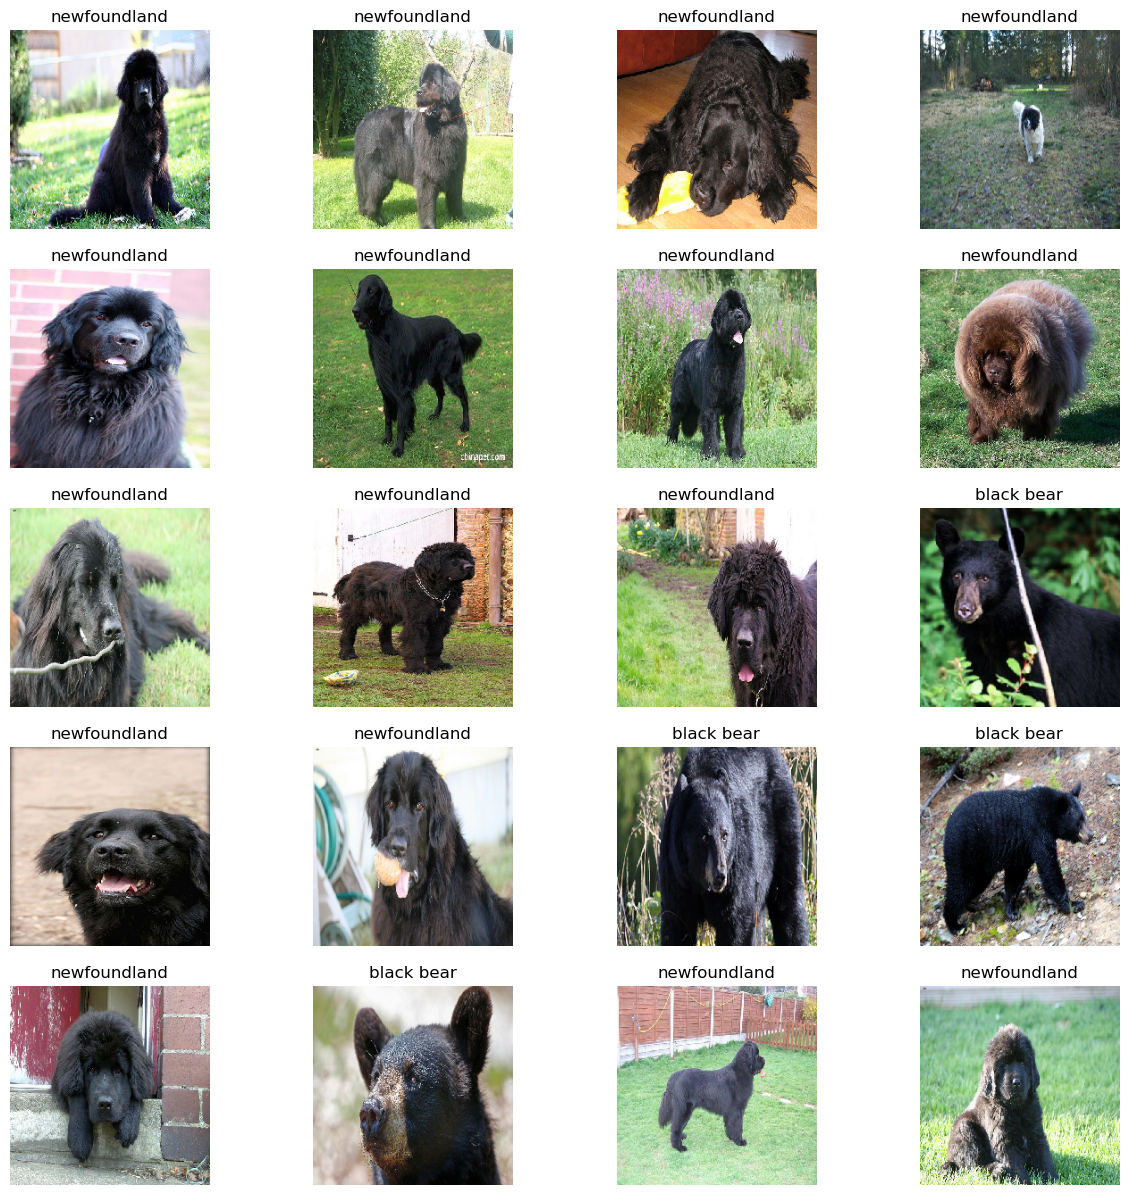

In [8]:
# Function to visualize images
def visualize_images(generator, num_images=20):
    images, labels = next(generator)  # Get a batch of images and labels
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 4, i + 1)
        plt.imshow(images[i])  # Display image
        class_label = labels[i].argmax()  # Get class label
        class_name = list(generator.class_indices.keys())[list(generator.class_indices.values()).index(class_label)]  # Get class name
        plt.title(class_name)  # Set title as class name
        plt.axis('off')
    plt.savefig('visualize_images.png')  # Save as image
    plt.show()

# Visualize images from the training set
visualize_images(train_generator)


4/4 [==============================] - 18s 3s/step


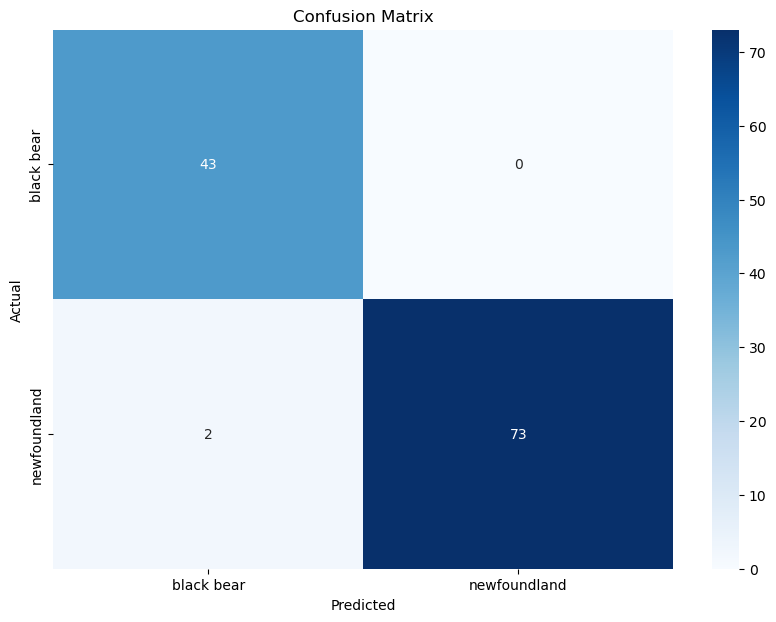

              precision    recall  f1-score   support

  black bear       0.96      1.00      0.98        43
newfoundland       1.00      0.97      0.99        75

    accuracy                           0.98       118
   macro avg       0.98      0.99      0.98       118
weighted avg       0.98      0.98      0.98       118



In [9]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)  # Plot heatmap
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')  # Save as image
    plt.show()

# Plot confusion matrix
y_pred = model.predict(test_generator)  # Predict on test data
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted classes
y_true = test_generator.classes  # True classes
cm = confusion_matrix(y_true, y_pred_classes)  # Compute confusion matrix
class_names = list(test_generator.class_indices.keys())  # Get class names
plot_confusion_matrix(cm, class_names)
print(classification_report(y_true, y_pred_classes, target_names=class_names))  # Print classification report


4/4 [==============================] - 14s 3s/step


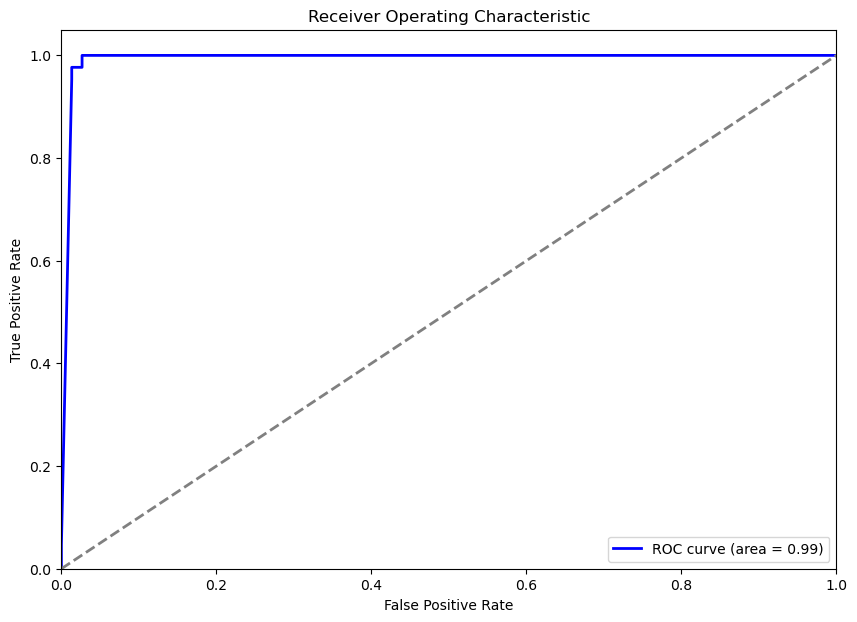

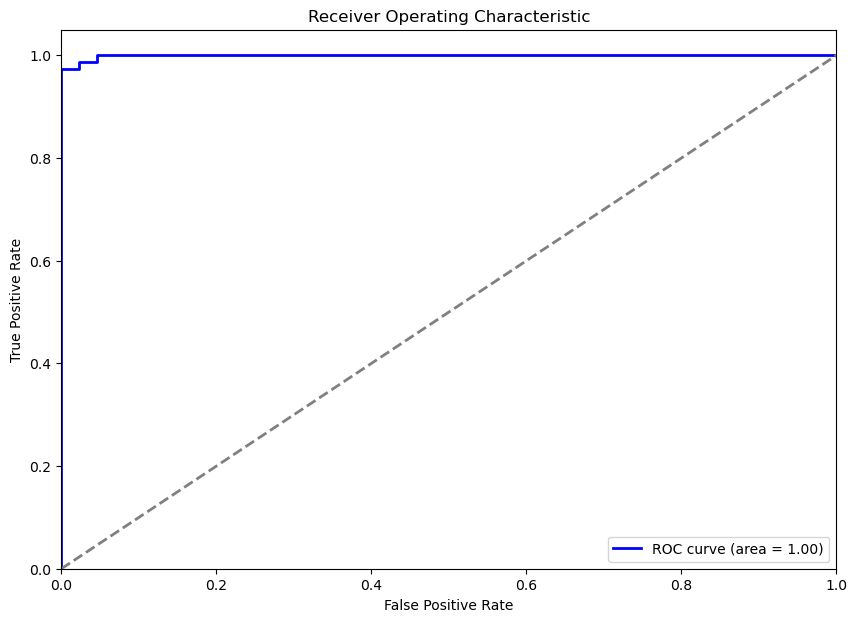

In [10]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Compute AUC

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)  # Plot ROC curve
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Plot diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')  # Save as image
    plt.show()

# Plot ROC curve for each class
y_true_binary = pd.get_dummies(y_true).values  # Convert true labels to binary format
y_pred_prob = model.predict(test_generator)  # Get predicted probabilities
for i in range(len(class_names)):
    plot_roc_curve(y_true_binary[:, i], y_pred_prob[:, i])  # Plot ROC curve for each class

1/1 [==============================] - 0s 157ms/step


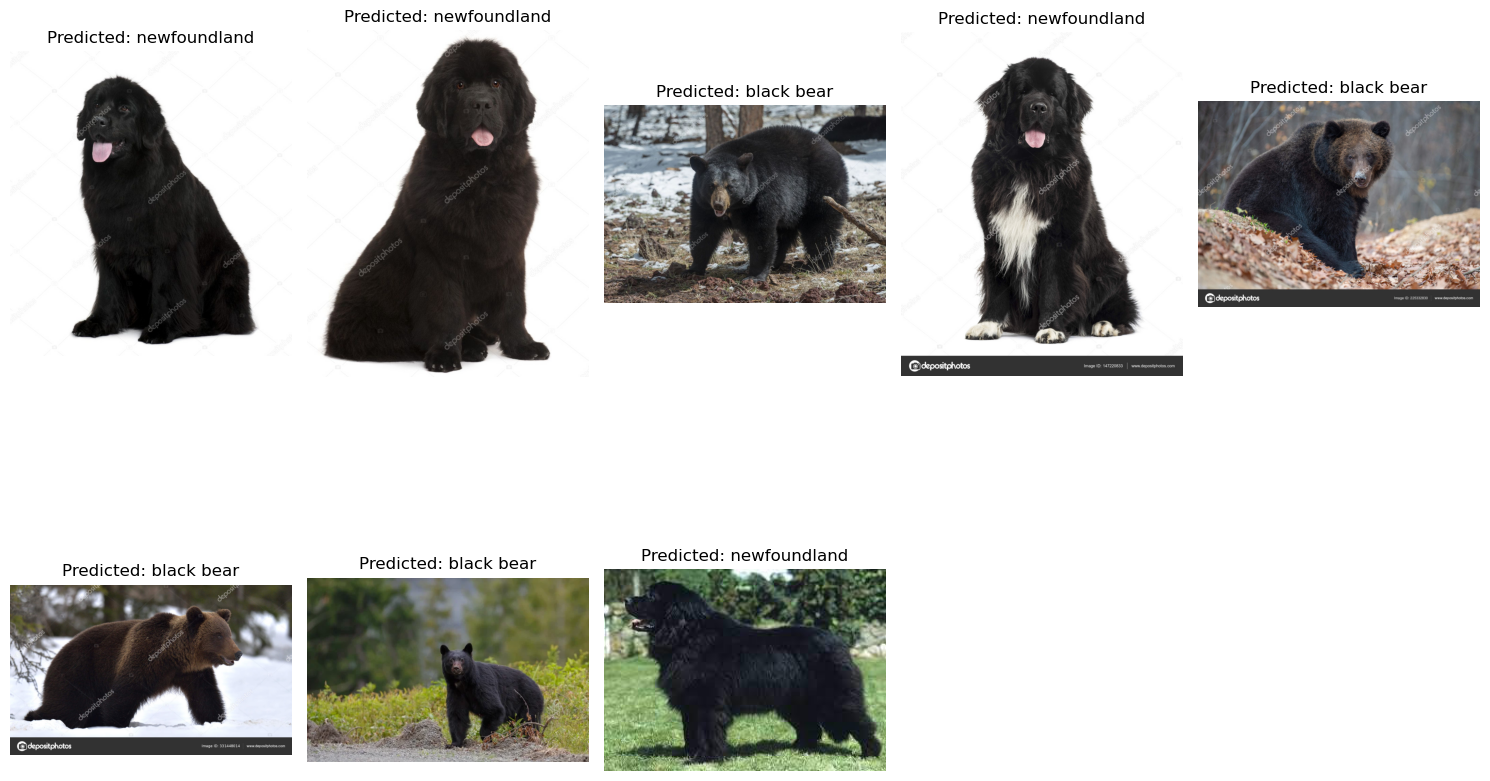

In [11]:
# Directory for unseen data
unseen_data_dir = "unseen_data"
unseen_images = [os.path.join(unseen_data_dir, img) for img in os.listdir(unseen_data_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Image preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load the image
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to fit model input
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to visualize classification results
def visualize_predictions(image_paths, model, class_labels):
    plt.figure(figsize=(15, 10))
    num_images = len(image_paths)
    num_images_per_row = 5
    num_rows = np.ceil(num_images / num_images_per_row).astype(int)
    
    for i, image_path in enumerate(image_paths):
        img_array = preprocess_image(image_path)
        prediction = model.predict(img_array)  # Predict the class
        predicted_class = class_labels[np.argmax(prediction)]  # Get the predicted class label
        
        plt.subplot(num_rows, num_images_per_row, i + 1)
        img = load_img(image_path)  # Load the image for visualization
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class}')  # Set the title as predicted class
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('unseen_data_predictions.png')  # Save as image
    plt.show()

# Define class labels
class_labels = ['black bear', 'newfoundland']

# Visualize classification results on the unseen dataset
visualize_predictions(unseen_images, model, class_labels)


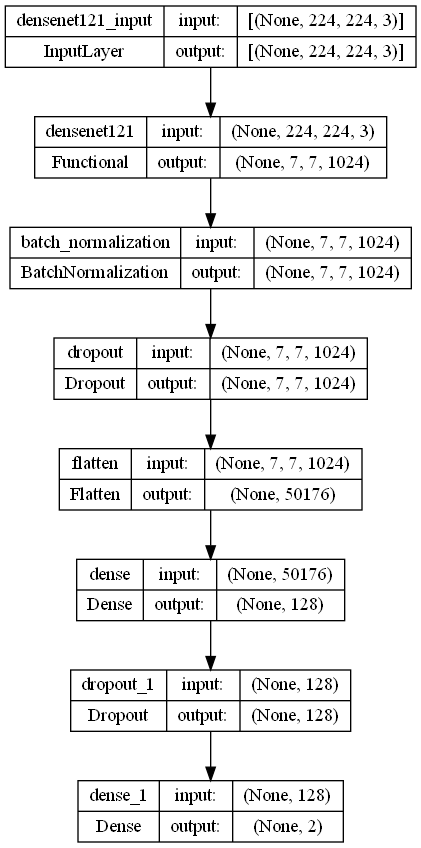

In [12]:
# Visualize the model structure
from tensorflow.keras.utils import plot_model

# Save the model structure to a file named 'model_structure.png'
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

# Import the Image display function from IPython
from IPython.display import Image

# Display the saved model structure image
Image(filename='model_structure.png')